## Introductions

This note is refered from Shan-Hung Wu's Deep Learning course from National Tsing Hua University. Here is the lecture notebook: https://nthu-datalab.github.io/ml/labs/03_Decision-Trees_Random-Forest/03_Decision-Tree_Random-Forest.html

In [1]:
%matplotlib inline

import os
from IPython.display import display
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import load_wine, load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## Decision Tree

In [2]:
df = pd.read_csv('http://mlr.cs.umass.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
              'Alcalinity of ash', 'Magnesium', 'Total phenols',
              'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 
              'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
df.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
X_origin = df.drop('Class label', axis=1)
Y_origin = df['Class label']

X_train, X_test, Y_train, Y_test = train_test_split(X_origin, Y_origin, test_size=0.3, random_state=0)
print("# of training examples:", X_train.shape[0])
print("# of testing examples:", X_test.shape[0])
print('Class labels:', np.unique(Y_origin))

# of training examples: 124
# of testing examples: 54
Class labels: [1 2 3]


In [4]:
%%time
dst = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
dst.fit(X_train, Y_train)

CPU times: user 2.32 ms, sys: 1.4 ms, total: 3.72 ms
Wall time: 10.1 ms


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [5]:
Y_pred = dst.predict(X_test)
Accuracy = (Y_pred == Y_test).sum() / Y_pred.shape[0]
print("Accuracy: %.2f" % Accuracy)

# a more convenient way to compute accuracy:
acc = accuracy_score(Y_test, Y_pred, normalize=True)
num_of_mis_samples = accuracy_score(Y_test, Y_pred, normalize=False)
print("Accuracy by sklean: %.2f" % acc)
print("# of Misclassified samples: %d" % num_of_mis_samples)

# We can assign the weights for each samples
'''
Signature: accuracy_score(y_true, y_pred, normalize=True, sample_weight=None)
- sample_weight : array-like of shape = [n_samples], optional
'''

Accuracy: 0.96
Accuracy by sklean: 0.96
# of Misclassified samples: 52


'\nSignature: accuracy_score(y_true, y_pred, normalize=True, sample_weight=None)\n- sample_weight : array-like of shape = [n_samples], optional\n'

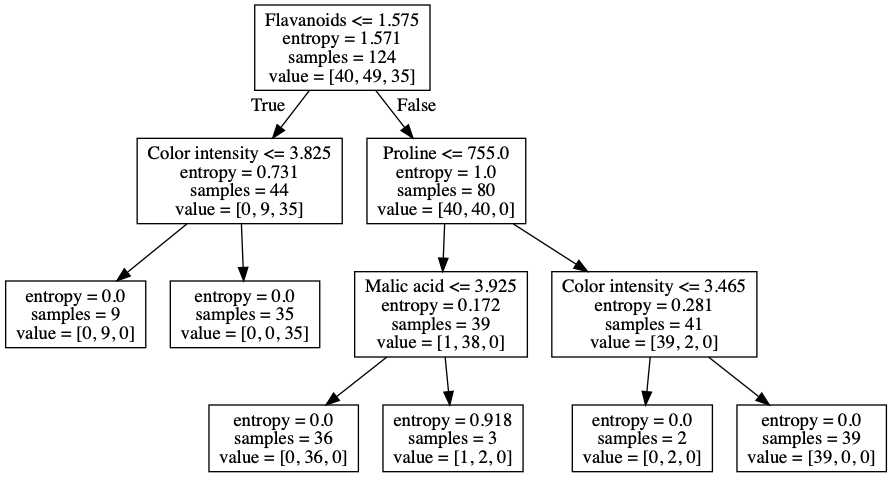

In [6]:
if not os.path.exists('./output/'):
    os.mkdir('./output')
    
export_graphviz(
    dst,
    out_file='./output/tree.dot',
    feature_names=X_origin.columns.values
)

# Before we use system command, we need to install graphviz first:
# sudo apt install graphviz
if not os.path.exists('./output/tree.png'):
    os.system('dot -Tpng ./output/tree.dot -o ./output/tree.png')
    
from PIL import Image
img = Image.open('./output/tree.png')
img

## Random Forests

In [7]:
%%time
forest = RandomForestClassifier(criterion='entropy',
                               n_estimators=10,
                               random_state=1,
                               n_jobs=2)
forest.fit(X_train, Y_train)

CPU times: user 14.4 ms, sys: 4.14 ms, total: 18.5 ms
Wall time: 115 ms


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
                       oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [8]:
Y_forest_pred = forest.predict(X_test)
print('Accuracy: %.2f' % accuracy_score(Y_test, Y_forest_pred))

Accuracy: 0.96


## Training Execution Time
We can use magic command: `%%time` to measure the execution for specific cell block and `%time` for a line expression e.g., `%time 2**128`. Besides, if we want to measure the execution time of a statement, `%timeit` is a proper choice. For example: `%timeit -r 4 u == None`. 

more details, please take a look: [IPython magic commands](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-time)


As we can see, the training time for building a DST is about 6ms, but 201 ms for building random forest. Next we will try to increase the number of estimators to see what happen?

In [9]:
%%time

# More estimators will increase the test accuracy, but the execution
# time for training model also grows siginificantly.
forest = RandomForestClassifier(criterion='entropy',
                               n_estimators=120,
                               random_state=1,
                               n_jobs=2)
forest.fit(X_train, Y_train)

CPU times: user 95.3 ms, sys: 16.4 ms, total: 112 ms
Wall time: 147 ms


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=2,
                       oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [10]:
Y_forest_pred = forest.predict(X_test)
print('Accuracy: %.2f' % accuracy_score(Y_test, Y_forest_pred))

Accuracy: 0.98


In [11]:
print("The shape of training data:", X_origin.shape)

importances = forest.feature_importances_
print(len(importances), importances)

# get sorted indices in descending order([::-1])
indices = np.argsort(importances)[::-1]
indices

The shape of training data: (178, 13)
13 [0.1073859  0.02090376 0.01216528 0.032737   0.01960773 0.05200354
 0.19178547 0.00827104 0.02721926 0.15197104 0.06641126 0.16046903
 0.14906968]


array([ 6, 11,  9, 12,  0, 10,  5,  3,  8,  1,  4,  2,  7])

 1) Flavanoids                     0.191785
 2) OD280/OD315 of diluted wines   0.160469
 3) Color intensity                0.151971
 4) Proline                        0.149070
 5) Alcohol                        0.107386
 6) Hue                            0.066411
 7) Total phenols                  0.052004
 8) Alcalinity of ash              0.032737
 9) Proanthocyanins                0.027219
10) Malic acid                     0.020904
11) Magnesium                      0.019608
12) Ash                            0.012165
13) Nonflavanoid phenols           0.008271


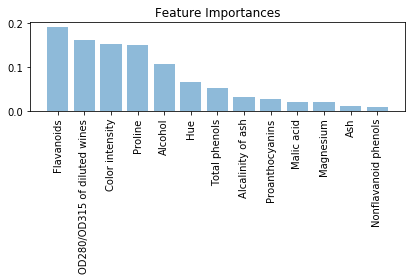

In [12]:
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f+1, 30,
                           X_origin.columns.values[indices[f]],
                           importances[indices[f]]))

plt.figure()
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]),
       importances[indices],
       align='center',
       alpha=0.5)

# rotation: rotate xtick labels so that the ticks would not
# be squeezed together.
plt.xticks(range(X_train.shape[1]),
           X_origin.columns.values[indices], rotation=90)
plt.tight_layout()

# save feature analysis fig.
# plt.savefig('./output/fig-forest-feature-importances.png', dpi=300)
plt.show()

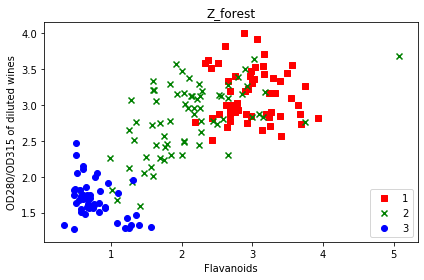

In [13]:
Z_forest = X_origin[['Flavanoids', 'OD280/OD315 of diluted wines']].values

colors = ['r', 'g', 'b']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(Y_origin.values), colors, markers):
    plt.scatter(Z_forest[Y_origin.values==l, 0],
               Z_forest[Y_origin.values==l, 1],
               c=c, label=l, marker=m)
    
plt.title('Z_forest')
plt.legend(loc='lower right')

# We also can hard coded these labels by "Flavanoids" ...
plt.xlabel(X_origin.columns.values[indices[0]])
plt.ylabel(X_origin.columns.values[indices[1]])
plt.tight_layout()
# save fig
# plt.savefig('./output/fig-forest-z.png', dpi=300)
plt.show()

In [14]:
# sklearn provided Selectex from model 
'''
Init signature:
SelectFromModel(
    estimator,
    threshold=None,
    prefit=False,
    norm_order=1,
    max_features=None,
)
'''
# put "prefitted" Random ForestClassifier "forest" into SelectFromModel
sfm = SelectFromModel(
        forest,
        threshold=0.16,
        prefit=True
)
Z_forest_alt = sfm.transform(X_origin)
for i in range(Z_forest_alt.shape[1]):
    print("%2d) %-*s %f" % (i+1, 30, 
          X_origin.columns.values[indices[i]],
         importances[indices[i]]))
    

 1) Flavanoids                     0.191785
 2) OD280/OD315 of diluted wines   0.160469


## Dimension Reduction: PCA vs. Random Forest
Both PCA and Random Forest can be used to reduce the dimension of data. But the big difference between PCA and Random Forest is that: PCA use unsupervised learning to do **feature extraction**. After doing the PCA, reduced data would not be identical to original one. On the other hands, Random Forest use supervised learning and evaluate the information gain to do **feature selection**. The reduced features are identical to origin data.

Let's compare their performance in the next section. We'll compare them on DecisionTreeClassifier first, and then use Random Forest to show more significant result.

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
sc = StandardScaler()

In [16]:
# Feature Selection
input_data = X_origin[['Flavanoids', 'OD280/OD315 of diluted wines']].values
Z_forest = sc.fit_transform(input_data)
# print(*zip(input_data, Z_forest_))

Z_forest_train, Z_forest_test, Y_forest_train, Y_forest_test = train_test_split(
    Z_forest, Y_origin, test_size=0.3, random_state=0
)
print('The shape of Z forest\'s training set:', Z_forest_train.shape)

tree_forest = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
tree_forest.fit(Z_forest_train, Y_forest_train)
Y_forest_predict = tree_forest.predict(Z_forest_test)
print('Accuracy: %.2f' % accuracy_score(Y_forest_test, Y_forest_predict))

The shape of Z forest's training set: (124, 2)
Accuracy: 0.83


In [17]:
# Training a PCA DST model without normalization
pca = PCA(n_components=2)
Z_pca = pca.fit_transform(X_origin)
print('shape of Z_pca:', Z_pca.shape)
print('Explained variance ratio:', pca.explained_variance_ratio_)


Z_pca_train, Z_pca_test, Y_pca_train, Y_pca_test = train_test_split(
    Z_pca, Y_origin, test_size=0.3, random_state=0
)
print('The shape of Z pca\'s training set:', Z_pca_train.shape)

tree_pca = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
tree_pca.fit(Z_pca_train, Y_pca_train)
Y_pca_predict = tree_pca.predict(Z_pca_test)
print('Accuracy: %.2f' % accuracy_score(Y_pca_test, Y_pca_predict))

shape of Z_pca: (178, 2)
Explained variance ratio: [0.99809123 0.00173592]
The shape of Z pca's training set: (124, 2)
Accuracy: 0.80


In [18]:
# Training a PCA DST model with normalization
Z = sc.fit_transform(X_origin)
pca = PCA(n_components=2)
Z_pca = pca.fit_transform(Z)
print('shape of Z_pca:', Z_pca.shape)
print('Explained variance ratio:', pca.explained_variance_ratio_)


Z_pca_train, Z_pca_test, Y_pca_train, Y_pca_test = train_test_split(
    Z_pca, Y_origin, test_size=0.3, random_state=0
)
print('The shape of Z pca\'s training set:', Z_pca_train.shape)

tree_pca = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
tree_pca.fit(Z_pca_train, Y_pca_train)
Y_pca_predict = tree_pca.predict(Z_pca_test)
print('Accuracy: %.2f' % accuracy_score(Y_pca_test, Y_pca_predict))

shape of Z_pca: (178, 2)
Explained variance ratio: [0.36198848 0.1920749 ]
The shape of Z pca's training set: (124, 2)
Accuracy: 0.96


In [19]:
# Train a random forest based on Z_forest.
forest_forest = RandomForestClassifier(criterion='entropy',
                                      n_estimators=120,
                                      random_state=1,
                                      n_jobs=2)
forest_forest.fit(Z_forest_train, Y_forest_train)
Y_forest_pred = forest_forest.predict(Z_forest_test)
print('Accuracy: %.2f' % accuracy_score(Y_pca_test, Y_forest_pred))

Accuracy: 0.67


In [20]:
# Train a random forest based on Z_pca
forest_pca = RandomForestClassifier(criterion='entropy',
                                      n_estimators=120,
                                      random_state=1,
                                      n_jobs=2)
forest_pca.fit(Z_pca_train, Y_pca_train)
Y_pca_pred = forest_pca.predict(Z_pca_test)
print('Accuracy: %.2f' % accuracy_score(Y_pca_test, Y_pca_pred))

Accuracy: 0.98


## Further Visualization
plotting decision region.

In [57]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.2):
    # set up marker generator and color map 
    markers = ['s', 'x', 'o', '^', 'v']
    colors = ['red', 'blue', 'lightgreen', 'gray', 'cyan']
    cmap = ListedColormap(colors[: len(np.unique(y))])
    
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))
    
    # np.ravel: return a continuous flattened array
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(
            x = X[y == cl, 0],
            y = X[y == cl, 1],
            alpha = 0.8,
            c = [cmap(idx)],
            marker = markers[idx],
            label = cl
        )
        
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        
        plt.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c='',
            alpha=1.0,
            linewidths=1,
            marker='o',
            s=55, label='test set', edgecolors='k')

[3 3 3 ... 1 1 1]


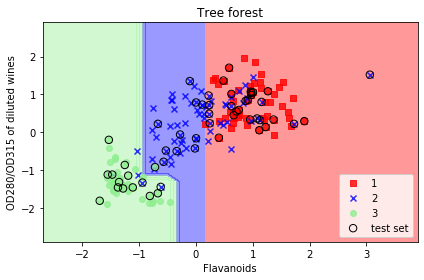

In [55]:
# plot boundaries of tree_forest
Z_forest_combined = np.vstack((Z_forest_train, Z_forest_test))
Y_forest_combined = np.hstack((Y_forest_train, Y_forest_test))
plot_decision_regions(
    Z_forest_combined,
    Y_forest_combined,
    classifier = tree_forest,
    test_idx = range(
        Y_forest_train.shape[0],
        Y_forest_train.shape[0] + Y_forest_test.shape[0]
    )
)

plt.title('Tree forest')
plt.xlabel('Flavanoids')
plt.ylabel('OD280/OD315 of diluted wines')
plt.legend(loc='lower right')
plt.tight_layout()
# plt.savefig('./output/fig-boundary-tree-forest.png', dpi=300)
plt.show()

[3 3 3 ... 2 2 2]


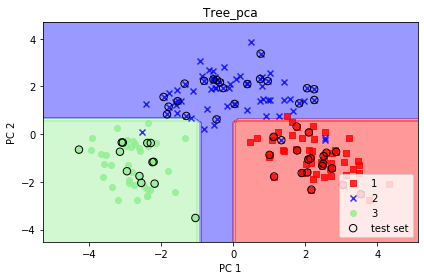

In [56]:
# plot the boundaries of tree_pca
Z_pca_combined = np.vstack((Z_pca_train, Z_pca_test))
Y_pca_combined = np.hstack((Y_pca_train, Y_pca_test))
plot_decision_regions(
    Z_pca_combined,
    Y_pca_combined,
    classifier = tree_pca,
    test_idx = range(
        Y_pca_train.shape[0],
        Y_pca_train.shape[0] + Y_pca_test.shape[0]
    )
)

plt.title('Tree_pca')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower right')
plt.tight_layout()
# plt.savefig('./output/fig-boundary-tree-pca.png', dpi=300)
plt.show()

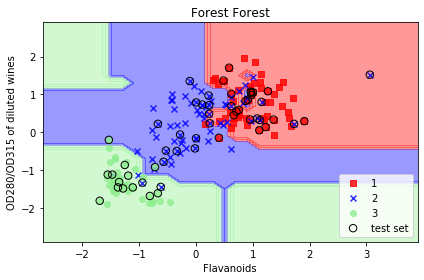

In [53]:
# plot boundaries of tree_forest
plot_decision_regions(
    Z_forest_combined,
    Y_forest_combined,
    classifier=forest_forest,
    test_idx=range(Y_forest_train.shape[0],
                   Y_forest_train.shape[0] + Y_forest_test.shape[0]))

plt.title('Forest Forest')
plt.xlabel('Flavanoids')
plt.ylabel('OD280/OD315 of diluted wines')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

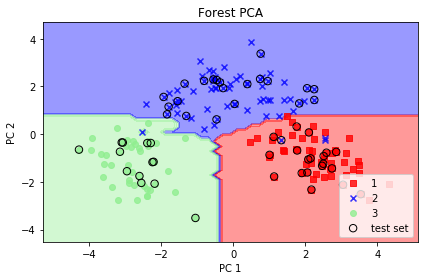

In [51]:
plot_decision_regions(
    Z_pca_combined,
    Y_pca_combined,
    classifier=forest_pca,
    test_idx=range(Y_pca_train.shape[0],
                   Y_pca_train.shape[0] + Y_pca_test.shape[0]))

plt.title('Forest PCA')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()